# Plant Pathology Classification
This notebook implements a plant disease classifier using EfficientNet-B2

## Import Dependencies

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import efficientnet_b2
from torchinfo import summary
from PIL import Image
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

## Constants

In [2]:
# Paths
DATA_DIR = Path('data/test')
TEST_DIR = Path('data/test')
MODEL_SAVE_PATH = 'best_model.pth'

# Training parameters
BATCH_SIZE = 32
NUM_EPOCHS = 20
LEARNING_RATE = 0.001
IMG_SIZE = 260
VAL_SPLIT = 0.2
TEST_SPLIT = 0.1

# Device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {DEVICE}')

# Class names
CLASS_NAMES = ['healthy', 'multiple_diseases', 'rust', 'scab']
NUM_CLASSES = len(CLASS_NAMES)

Using device: cuda


## Create Test Set

In [3]:
import shutil
import random

# Create test directory structure if it doesn't exist
if not TEST_DIR.exists():
    TEST_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Created test directory: {TEST_DIR}')
    
    # Move 10% of images from each class to test set
    for class_name in CLASS_NAMES:
        train_class_dir = DATA_DIR / class_name
        test_class_dir = TEST_DIR / class_name
        test_class_dir.mkdir(parents=True, exist_ok=True)
        
        # Get all images in this class
        all_images = list(train_class_dir.glob('*.jpg'))
        
        # Calculate number of test images (10%)
        num_test = int(len(all_images) * TEST_SPLIT)
        
        # Randomly select images for test set
        random.seed(42)
        test_images = random.sample(all_images, num_test)
        
        # Move images from train to test
        for img_path in test_images:
            dest_path = test_class_dir / img_path.name
            shutil.move(str(img_path), str(dest_path))
        
        print(f'{class_name}: Moved {num_test} images to test set ({len(all_images)} total)')
    
    print(f'\nTest set created successfully!')
else:
    print(f'Test directory already exists: {TEST_DIR}')
    # Show test set statistics
    for class_name in CLASS_NAMES:
        test_class_dir = TEST_DIR / class_name
        if test_class_dir.exists():
            num_test_images = len(list(test_class_dir.glob('*.jpg')))
            print(f'{class_name}: {num_test_images} test images')

Test directory already exists: data\test
healthy: 51 test images
multiple_diseases: 9 test images
rust: 62 test images
scab: 59 test images


## Image Generators

In [4]:
# Prepare training data
train_image_paths = []
train_labels = []

for class_idx, class_name in enumerate(CLASS_NAMES):
    class_dir = DATA_DIR / class_name
    for img_path in class_dir.glob('*.jpg'):
        train_image_paths.append(str(img_path))
        train_labels.append(class_idx)

print(f'Training images: {len(train_image_paths)}')

# Split training data into train and validation
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_image_paths, train_labels, test_size=VAL_SPLIT, random_state=42, stratify=train_labels
)

print(f'Train split: {len(train_paths)}')
print(f'Validation split: {len(val_paths)}')

# Prepare test data
test_image_paths = []
test_labels = []

for class_idx, class_name in enumerate(CLASS_NAMES):
    class_dir = TEST_DIR / class_name
    for img_path in class_dir.glob('*.jpg'):
        test_image_paths.append(str(img_path))
        test_labels.append(class_idx)

print(f'Test images: {len(test_image_paths)}')

Training images: 181
Train split: 144
Validation split: 37
Test images: 181


In [25]:
class PlantPathologyDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Data augmentation and normalization
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = PlantPathologyDataset(train_paths, train_labels, train_transform)
val_dataset = PlantPathologyDataset(val_paths, val_labels, test_transform)
test_dataset = PlantPathologyDataset(test_image_paths, test_labels, test_transform)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Created dataloaders: train={len(train_loader)} batches, val={len(val_loader)} batches, test={len(test_loader)} batches')

Created dataloaders: train=5 batches, val=2 batches, test=6 batches


## Custom PyTorch Model (EfficientNet B2)

In [26]:
class PlantPathologyModel(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(PlantPathologyModel, self).__init__()
        # Load pretrained EfficientNet B2
        self.backbone = efficientnet_b2(pretrained=True)
        
        # Get the number of input features for the classifier
        in_features = self.backbone.classifier[1].in_features
        
        # Replace the classifier
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=0.3, inplace=True),
            nn.Linear(in_features, num_classes)
        )
    
    def forward(self, x):
        return self.backbone(x)


In [27]:
# Initialize model
model = PlantPathologyModel(num_classes=NUM_CLASSES).to(DEVICE)
print(f'Model created and moved to {DEVICE}')
summary(model)

Model created and moved to cuda


Layer (type:depth-idx)                                       Param #
PlantPathologyModel                                          --
├─EfficientNet: 1-1                                          --
│    └─Sequential: 2-1                                       --
│    │    └─ConvNormActivation: 3-1                          928
│    │    └─Sequential: 3-2                                  2,060
│    │    └─Sequential: 3-3                                  27,424
│    │    └─Sequential: 3-4                                  103,134
│    │    └─Sequential: 3-5                                  421,550
│    │    └─Sequential: 3-6                                  862,768
│    │    └─Sequential: 3-7                                  3,048,878
│    │    └─Sequential: 3-8                                  2,735,820
│    │    └─ConvNormActivation: 3-9                          498,432
│    └─AdaptiveAvgPool2d: 2-2                                --
│    └─Sequential: 2-3                                   

## Train the Model

In [28]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

In [29]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(dataloader, desc='Training'):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [30]:
# Training loop
best_val_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(NUM_EPOCHS):
    print(f'\nEpoch {epoch+1}/{NUM_EPOCHS}')
    print('-' * 50)
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = validate(model, val_loader, criterion, DEVICE)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'val_loss': val_loss,
        }, MODEL_SAVE_PATH)
        print(f'Best model saved with validation accuracy: {val_acc:.2f}%')
    
    scheduler.step(val_loss)

print(f'\nTraining completed! Best validation accuracy: {best_val_acc:.2f}%')


Epoch 1/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:02<00:00,  1.01s/it]


Train Loss: 1.0651, Train Acc: 52.08%
Val Loss: 0.8842, Val Acc: 62.16%
Best model saved with validation accuracy: 62.16%

Epoch 2/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]


Train Loss: 0.4176, Train Acc: 86.11%
Val Loss: 0.8934, Val Acc: 64.86%
Best model saved with validation accuracy: 64.86%

Epoch 3/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Train Loss: 0.3272, Train Acc: 95.83%
Val Loss: 0.5004, Val Acc: 81.08%
Best model saved with validation accuracy: 81.08%

Epoch 4/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Train Loss: 0.1520, Train Acc: 95.14%
Val Loss: 0.5643, Val Acc: 83.78%
Best model saved with validation accuracy: 83.78%

Epoch 5/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


Train Loss: 0.2437, Train Acc: 91.67%
Val Loss: 0.7215, Val Acc: 81.08%

Epoch 6/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Train Loss: 0.1077, Train Acc: 97.22%
Val Loss: 0.8758, Val Acc: 86.49%
Best model saved with validation accuracy: 86.49%
Epoch     6: reducing learning rate of group 0 to 5.0000e-04.

Epoch 7/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


Train Loss: 0.1974, Train Acc: 95.83%
Val Loss: 0.5755, Val Acc: 86.49%

Epoch 8/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Train Loss: 0.0817, Train Acc: 96.53%
Val Loss: 0.4182, Val Acc: 89.19%
Best model saved with validation accuracy: 89.19%

Epoch 9/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Train Loss: 0.1329, Train Acc: 95.14%
Val Loss: 0.2640, Val Acc: 91.89%
Best model saved with validation accuracy: 91.89%

Epoch 10/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Train Loss: 0.0345, Train Acc: 99.31%
Val Loss: 0.1619, Val Acc: 91.89%

Epoch 11/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Train Loss: 0.0857, Train Acc: 97.92%
Val Loss: 0.1361, Val Acc: 94.59%
Best model saved with validation accuracy: 94.59%

Epoch 12/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Train Loss: 0.1041, Train Acc: 97.92%
Val Loss: 0.1945, Val Acc: 91.89%

Epoch 13/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]


Train Loss: 0.0399, Train Acc: 99.31%
Val Loss: 0.2678, Val Acc: 91.89%

Epoch 14/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Train Loss: 0.0261, Train Acc: 98.61%
Val Loss: 0.3402, Val Acc: 89.19%
Epoch    14: reducing learning rate of group 0 to 2.5000e-04.

Epoch 15/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Train Loss: 0.0199, Train Acc: 100.00%
Val Loss: 0.2761, Val Acc: 91.89%

Epoch 16/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Train Loss: 0.0242, Train Acc: 99.31%
Val Loss: 0.2144, Val Acc: 94.59%

Epoch 17/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]


Train Loss: 0.0165, Train Acc: 100.00%
Val Loss: 0.1903, Val Acc: 94.59%
Epoch    17: reducing learning rate of group 0 to 1.2500e-04.

Epoch 18/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.25it/s]


Train Loss: 0.0140, Train Acc: 100.00%
Val Loss: 0.2012, Val Acc: 94.59%

Epoch 19/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]


Train Loss: 0.0454, Train Acc: 98.61%
Val Loss: 0.2019, Val Acc: 94.59%

Epoch 20/20
--------------------------------------------------


Validation: 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

Train Loss: 0.0292, Train Acc: 98.61%
Val Loss: 0.2046, Val Acc: 94.59%
Epoch    20: reducing learning rate of group 0 to 6.2500e-05.

Training completed! Best validation accuracy: 94.59%


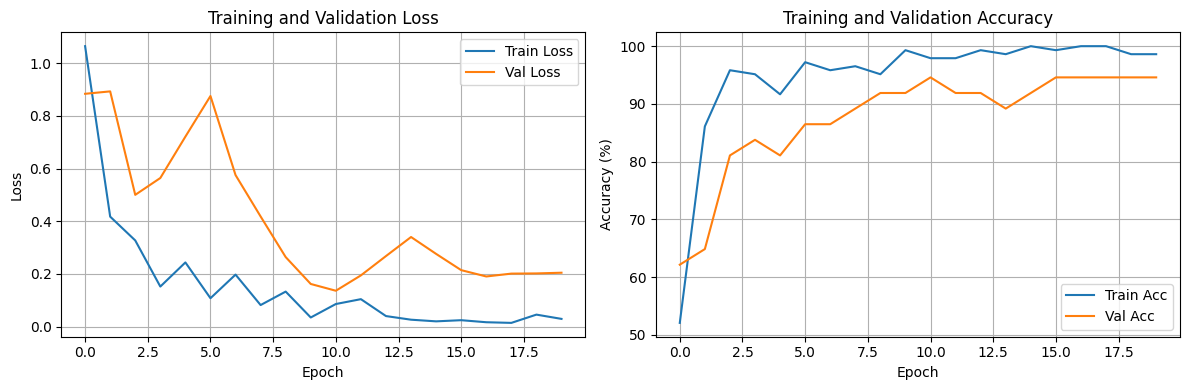

In [31]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(train_losses, label='Train Loss')
ax1.plot(val_losses, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True)

ax2.plot(train_accs, label='Train Acc')
ax2.plot(val_accs, label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

## Test the Model

In [32]:
# Load best model
checkpoint = torch.load(MODEL_SAVE_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%")

Loaded best model from epoch 11
Best validation accuracy: 94.59%


Testing: 100%|██████████| 6/6 [00:06<00:00,  1.03s/it]


Classification Report:
                   precision    recall  f1-score   support

          healthy       0.98      1.00      0.99        51
multiple_diseases       1.00      0.89      0.94         9
             rust       1.00      1.00      1.00        62
             scab       0.98      0.98      0.98        59

         accuracy                           0.99       181
        macro avg       0.99      0.97      0.98       181
     weighted avg       0.99      0.99      0.99       181



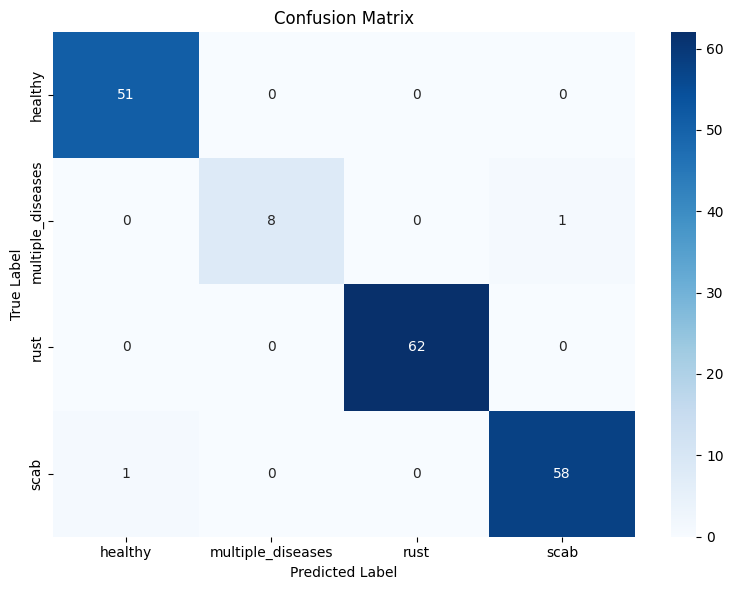

In [33]:
# Test on test set with detailed metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc='Testing'):
        images = images.to(DEVICE)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Classification report
print('\nClassification Report:')
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()